In [38]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib


#
# TODO: Parameters to play around with
PLOT_TYPE_TEXT = False    # If you'd like to see indices
PLOT_VECTORS = True       # If you'd like to see your original features in P.C.-Space


matplotlib.style.use('ggplot') # Look Pretty
c = ['red', 'green', 'blue', 'orange', 'yellow', 'brown']

def drawVectors(transformed_features, components_, columns, plt):
    num_columns = len(columns)
    # Scale the principal components by the max value in the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ## Visualize projections

    # Sort each column by its length. These are your *original*
    # columns, not the principal components.
    import math
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print "Projected Features by importance:\n", important_features

    ax = plt.axes()

    for i in range(num_columns):
        # Use an arrow to project each original feature as a
        # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75, zorder=600000)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75, zorder=600000)
    return ax
    

def doPCA(data, dimensions=2):
    from sklearn.decomposition import RandomizedPCA
    model = RandomizedPCA(n_components=dimensions)
    model.fit(data)
    return model

In [40]:
def doKMeans(data, clusters=0):
    kmeans = KMeans(n_clusters=clusters)
    model = kmeans.fit(data)
    centroids = model.cluster_centers_
    return model.cluster_centers_, model.labels_

Load up the dataset. It has may or may not have nans in it. Make sure you catch them and destroy them, by setting them to '0'. This is valid for this dataset, since if the value is missing, you can assume no $ was spent on it.

In [26]:
df = pd.read_csv('./Datasets/Wholesale customers data.csv')

In [27]:
df.head(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844


In [28]:
df.columns

Index([u'Channel', u'Region', u'Fresh', u'Milk', u'Grocery', u'Frozen',
       u'Detergents_Paper', u'Delicassen'],
      dtype='object')

In [29]:
df.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [30]:
df = df.fillna(value=0)

As instructed, get rid of the 'Channel' and 'Region' columns, since you'll be investigating as if this were a single location wholesaler, rather than a national / international one. Leaving these fields in here would cause KMeans to examine and give weight to them.

In [31]:
df = df.drop(['Channel', 'Region'], axis=1)

Before unitizing / standardizing / normalizing your data in preparation for K-Means, it's a good idea to get a quick peek at it. You can do this using the  .describe() method, or even by using the built-in pandas df.plot.hist()

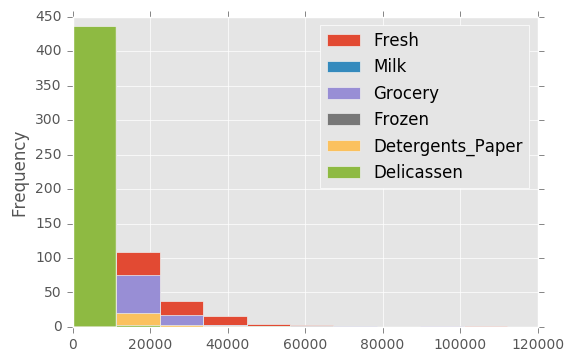

In [32]:
df.plot.hist()

In [33]:
df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Remove top 5 and bottom 5 samples for each column

In [34]:
drop = {}
for col in df.columns:
    # Bottom 5
    sort = df.sort_values(by=col, ascending=True)
    if len(sort) > 5: sort=sort[:5]
    for index in sort.index: drop[index] = True # Just store the index once

    # Top 5
    sort = df.sort_values(by=col, ascending=False)
    if len(sort) > 5: sort=sort[:5]
    for index in sort.index: drop[index] = True # Just store the index once

#
# INFO Drop rows by index. We do this all at once in case there is a
# collision. This way, we don't end up dropping more rows than we have
# to, if there is a single row that satisfies the drop for multiple columns.
# Since there are 6 rows, if we end up dropping < 5*6*2 = 60 rows, that means
# there indeed were collisions.
print "Dropping {0} Outliers...".format(len(drop))
df.drop(inplace=True, labels=drop.keys(), axis=0)
print df.describe()

Dropping 42 Outliers...
              Fresh          Milk       Grocery        Frozen  \
count    398.000000    398.000000    398.000000    398.000000   
mean   10996.231156   5144.090452   7091.711055   2639.721106   
std     9933.042596   5057.406574   6923.019293   2974.246906   
min       37.000000    258.000000    314.000000     47.000000   
25%     3324.500000   1571.250000   2155.500000    749.750000   
50%     8257.500000   3607.500000   4573.000000   1526.000000   
75%    15828.500000   6953.250000   9922.250000   3370.250000   
max    53205.000000  29892.000000  39694.000000  17866.000000   

       Detergents_Paper   Delicassen  
count        398.000000   398.000000  
mean        2562.974874  1278.736181  
std         3608.176776  1220.745297  
min           10.000000    11.000000  
25%          273.250000   409.500000  
50%          812.000000   946.500000  
75%         3841.500000  1752.250000  
max        19410.000000  7844.000000  


Normalization of prices

In [36]:
T = preprocessing.StandardScaler().fit_transform(df)
#T = preprocessing.StandardScaler().fit_transform(df)
#T = preprocessing.MinMaxScaler().fit_transform(df)
#T = preprocessing.MaxAbsScaler().fit_transform(df)
#T = preprocessing.Normalizer().fit_transform(df)
# T = df # No Change

PCA and KMeans

In [42]:
def analyze(T, n_clusters=3):
    centroids, labels = doKMeans(T, n_clusters)
    print(centroids)

    # Do PCA *after* to visualize the results. Project the centroids as well as 
    # the samples into the new 2D feature space for visualization purposes.
    display_pca = doPCA(T)
    T = display_pca.transform(T)
    CC = display_pca.transform(centroids)


    # Visualize all the samples. Give them the color of their cluster label
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if PLOT_TYPE_TEXT:
            # Plot the index of the sample, so you can further investigate it in your dset
            for i in range(len(T)): ax.text(T[i,0], T[i,1], df.index[i], color=c[labels[i]], alpha=0.75, zorder=600000)
            ax.set_xlim(min(T[:,0])*1.2, max(T[:,0])*1.2)
            ax.set_ylim(min(T[:,1])*1.2, max(T[:,1])*1.2)
    else:
            # Plot a regular scatter plot
            sample_colors = [ c[labels[i]] for i in range(len(T)) ]
            ax.scatter(T[:, 0], T[:, 1], c=sample_colors, marker='o', alpha=0.2)


    # Plot the Centroids as X's, and label them
    ax.scatter(CC[:, 0], CC[:, 1], marker='x', s=169, linewidths=3, zorder=1000, c=c)
    for i in range(len(centroids)): ax.text(CC[i, 0], CC[i, 1], str(i), zorder=500010, fontsize=18, color=c[i])


    # Display feature vectors for investigation:
    if PLOT_VECTORS: drawVectors(T, display_pca.components_, df.columns, plt)


    # Add the cluster label back into the dataframe and display it:
    df['label'] = pd.Series(labels, index=df.index)
    print(df)

    plt.show()

[[-0.56995352  1.31744707  1.58541223 -0.33454978  1.59481374  0.27849802
   1.56217032]
 [-0.26232459 -0.41632038 -0.43893222 -0.29733807 -0.38963897 -0.32590196
   0.02700047]
 [ 1.20725644 -0.12927099 -0.31707856  1.08169261 -0.45400669  0.59174102
  -1.50816937]]
Projected Features by importance:
[(3.7713226476548063, 'Grocery'), (3.7204776159227175, 'Detergents_Paper'), (3.6643540066386393, 'label'), (3.571739537737412, 'Milk'), (2.7088703211644183, 'Delicassen'), (2.7009396707303983, 'Fresh'), (2.511281000534469, 'Frozen')]
     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen  label
0    12669   9656     7561     214              2674        1338      1
1     7057   9810     9568    1762              3293        1776      1
2     6353   8808     7684    2405              3516        7844      2
3    13265   1196     4221    6404               507        1788      2
4    22615   5410     7198    3915              1777        5185      2
5     9413   8259     5126     6

/home/faris/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


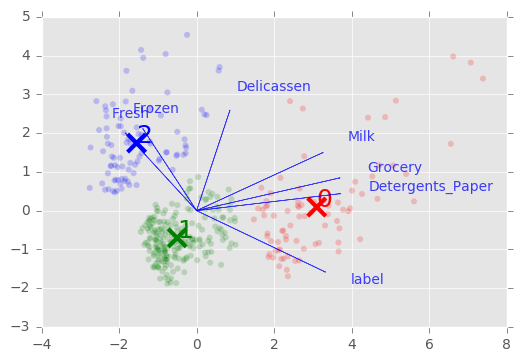

In [44]:
T = preprocessing.StandardScaler().fit_transform(df)
analyze(T)

[[  1.57177726e-01   9.39203553e-02   9.50430361e-02   9.59355734e-02
    5.92193760e-02   1.11118730e-01   5.00000000e-01]
 [  9.97775976e-02   3.89437141e-01   4.50476208e-01   8.97322112e-02
    4.27840779e-01   2.05193917e-01   2.22044605e-16]
 [  4.31385163e-01   1.42847282e-01   1.16438028e-01   3.25826238e-01
    4.72627694e-02   2.53950362e-01   1.00000000e+00]]
Projected Features by importance:
[(0.9366958089330935, 'label'), (0.5472076930815538, 'Grocery'), (0.5438090921225441, 'Milk'), (0.5435255576637553, 'Detergents_Paper'), (0.464333482889295, 'Fresh'), (0.42527323667302586, 'Delicassen'), (0.3550419663581062, 'Frozen')]
     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen  label
0    12669   9656     7561     214              2674        1338      0
1     7057   9810     9568    1762              3293        1776      0
2     6353   8808     7684    2405              3516        7844      2
3    13265   1196     4221    6404               507        1788     

/home/faris/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


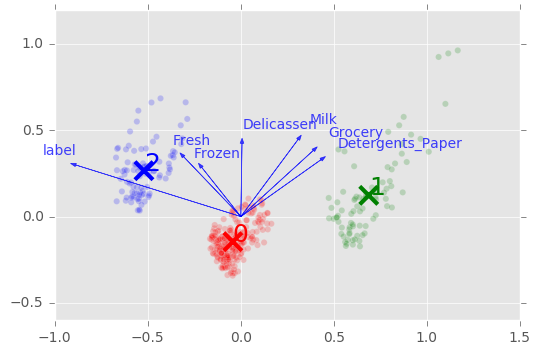

In [45]:
T = preprocessing.MinMaxScaler().fit_transform(df)
analyze(T)

[[  4.31780591e-01   1.50245429e-01   1.23427459e-01   3.27599783e-01
    4.77536181e-02   2.54996581e-01   1.00000000e+00]
 [  1.57763844e-01   1.01740794e-01   1.02201712e-01   9.83138913e-02
    5.97040647e-02   1.12365249e-01   1.55431223e-15]
 [  1.00403633e-01   3.94706953e-01   4.54823225e-01   9.21268483e-02
    4.28135554e-01   2.06308510e-01   5.00000000e-01]]
Projected Features by importance:
[(0.8202531445396655, 'label'), (0.7530720084044384, 'Detergents_Paper'), (0.702829541002241, 'Grocery'), (0.6080825297682552, 'Milk'), (0.43934308377039616, 'Fresh'), (0.3038461188208484, 'Frozen'), (0.2030266562674436, 'Delicassen')]
     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen  label
0    12669   9656     7561     214              2674        1338      1
1     7057   9810     9568    1762              3293        1776      1
2     6353   8808     7684    2405              3516        7844      0
3    13265   1196     4221    6404               507        1788     

/home/faris/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


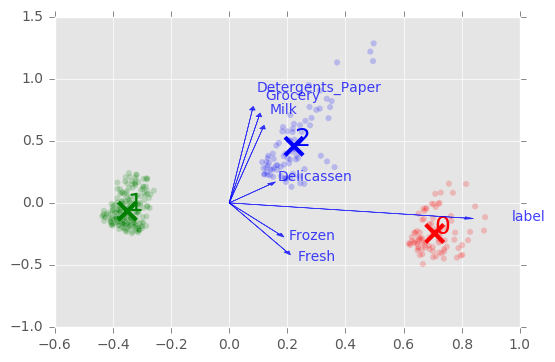

In [46]:
T = preprocessing.MaxAbsScaler().fit_transform(df)
analyze(T)

/home/faris/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
/home/faris/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


[[  7.03965650e-01   2.16174747e-01   2.48614457e-01   5.31281227e-01
    5.03005453e-02   9.76587563e-02   8.17158408e-05]
 [  2.68414397e-01   4.93883070e-01   6.70486325e-01   1.08982331e-01
    2.64527671e-01   1.03215578e-01   1.13423356e-04]
 [  9.14904036e-01   1.70146686e-01   2.35586993e-01   1.18413456e-01
    5.37288480e-02   6.76299126e-02   5.84664249e-05]]
Projected Features by importance:
[(0.6981434432456227, 'Frozen'), (0.607584108463748, 'Fresh'), (0.4507160877760969, 'Grocery'), (0.2806970326232431, 'Milk'), (0.23050289809358765, 'Detergents_Paper'), (0.07434865036340238, 'Delicassen'), (4.762383703187112e-05, 'label')]
     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen  label
0    12669   9656     7561     214              2674        1338      2
1     7057   9810     9568    1762              3293        1776      1
2     6353   8808     7684    2405              3516        7844      1
3    13265   1196     4221    6404               507        1788 

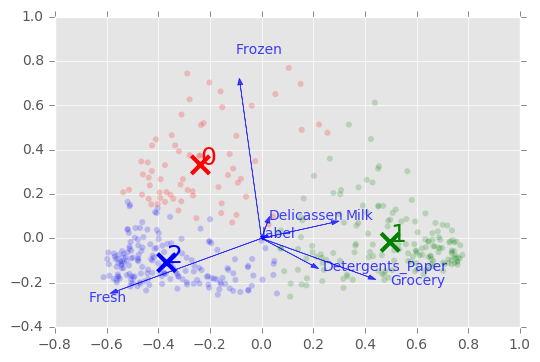

In [47]:
T = preprocessing.Normalizer().fit_transform(df)
analyze(T)

[[  6.98888546e+03   3.29195595e+03   4.07160793e+03   2.46087225e+03
    1.21600441e+03   1.03018502e+03   1.15418502e+00]
 [  2.53947292e+04   4.04512500e+03   5.21907292e+03   3.80859375e+03
    1.13041667e+03   1.61495833e+03   1.75000000e+00]
 [  4.69505333e+03   1.21565600e+04   1.86295333e+04   1.68488000e+03
    8.47348000e+03   1.60065333e+03   1.00000000e+00]]
Projected Features by importance:
[(37457.237943044616, 'Fresh'), (29687.70550064634, 'Grocery'), (19639.849685386125, 'Milk'), (14205.58195269668, 'Detergents_Paper'), (2827.8619983694575, 'Frozen'), (2050.96994975757, 'Delicassen'), (1.212952952020928, 'label')]
     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen  label
0    12669   9656     7561     214              2674        1338      0
1     7057   9810     9568    1762              3293        1776      0
2     6353   8808     7684    2405              3516        7844      0
3    13265   1196     4221    6404               507        1788      0
4 

/home/faris/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


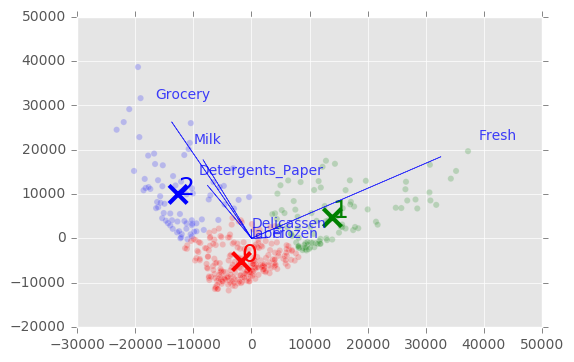

In [48]:
T = df
analyze(T)